Retrieving S&P 500 constituents list...
Found 503 constituents
Processing MMM...
Processing AOS...
Processing ABT...
Processing ABBV...
Processing ACN...
Processing ADBE...
Processing AMD...
Processing AES...
Processing AFL...
Processing A...
Processing APD...
Processing ABNB...
Processing AKAM...
Processing ALB...
Processing ARE...
Processing ALGN...
Processing ALLE...
Processing LNT...
Processing ALL...
Processing GOOGL...
Processing GOOG...
Processing MO...
Processing AMZN...
Processing AMCR...
Processing AEE...
Processing AEP...
Processing AXP...
Processing AIG...
Processing AMT...
Processing AWK...
Processing AMP...
Processing AME...
Processing AMGN...
Processing APH...
Processing ADI...
Processing AON...
Processing APA...
Processing APO...
Processing AAPL...
Processing AMAT...
Processing APTV...
Processing ACGL...
Processing ADM...
Processing ANET...
Processing AJG...
Processing AIZ...
Processing T...
Processing ATO...
Processing ADSK...
Processing ADP...
Processing AZO...
Proces

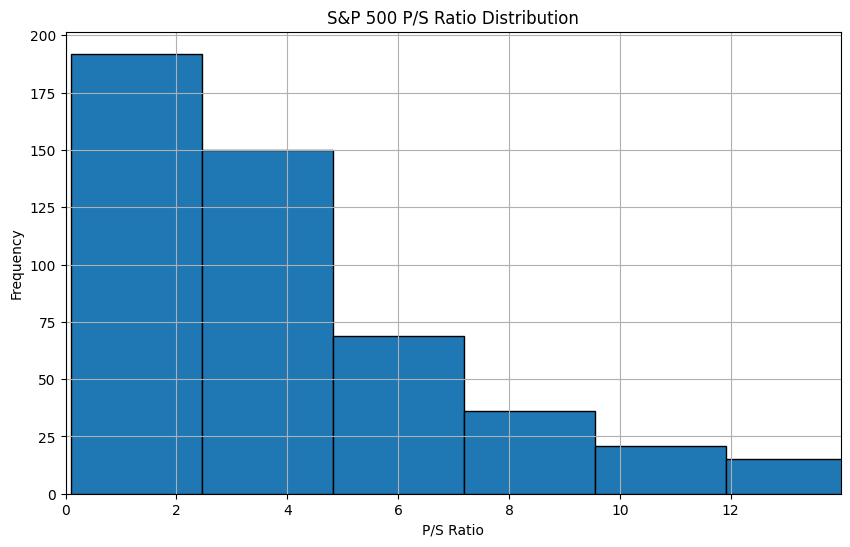

In [1]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
import warnings
import time

# Function: Get the list of S&P 500 constituent tickers
def get_sp500_tickers(max_retries=3, delay=2):
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning, module="bs4")
                soup = BeautifulSoup(response.text, 'html.parser')
            
            table = soup.find('table', {'id': 'constituents'})
            if not table:
                print("S&P 500 constituents table not found")
                return []
            
            tickers = []
            for row in table.find_all('tr')[1:]:
                cells = row.find_all('td')
                if len(cells) > 0:
                    ticker = cells[0].text.strip().replace('.', '-')
                    tickers.append(ticker)
            return tickers
        
        except requests.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                print(f"Retrying after {delay} seconds...")
                time.sleep(delay)
            else:
                print("Max retries reached. Returning empty list for S&P 500.")
                return []

# Function: Get the list of Nasdaq 100 constituent tickers
def get_nasdaq100_tickers(max_retries=3, delay=2):
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning, module="bs4")
                soup = BeautifulSoup(response.text, 'html.parser')
            
            tables = soup.find_all('table', class_='wikitable')
            if len(tables) < 2:
                print("Nasdaq-100 constituents table not found")
                return [
                    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'ADBE', 'NFLX', 'CSCO',
                    'INTC', 'AMD', 'QCOM', 'TXN', 'AMAT', 'MU', 'LRCX', 'ASML', 'CMCSA', 'PEP',
                ]
            
            table = tables[1]
            tickers = []
            for row in table.find_all('tr')[1:]:
                cells = row.find_all('td')
                if len(cells) > 1:
                    ticker = cells[1].text.strip().replace('.', '-')
                    tickers.append(ticker)
            return tickers
        
        except requests.RequestException as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < max_retries - 1:
                print(f"Retrying after {delay} seconds...")
                time.sleep(delay)
            else:
                print("Max retries reached. Using fallback Nasdaq-100 ticker list.")
                return [
                    'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'NVDA', 'ADBE', 'NFLX', 'CSCO',
                ]

# Function: Get the list of HACK ETF constituent tickers
def get_hack_tickers():
    print("Note: HACK ETF constituents list is hardcoded, recommend updating from official source")
    return ['CRWD', 'CSCO', 'PANW', 'FTNT', 'ZS', 'CHKP', 'GEN', 'OKTA', 'S', 'BAH']

# Function: Calculate the P/S ratio for a single stock
def get_ps_ratio(ticker):
    try:
        stock = yf.Ticker(ticker)
        info = stock.info
        market_cap = info.get('marketCap', None)
        revenue = info.get('totalRevenue', None)
        
        if market_cap and revenue and revenue > 0:
            ps_ratio = market_cap / revenue
            return ps_ratio
        else:
            print(f"{ticker}: Missing or invalid marketCap/revenue")
            return None
    except Exception as e:
        print(f"Unable to retrieve data for {ticker}: {e}")
        return None

# Function: Recalculate and save data
def calculate_and_save_data(index_type):
    if index_type == 'sp500':
        print("Retrieving S&P 500 constituents list...")
        tickers = get_sp500_tickers()
        excel_file = 'sp500_ps_ratio.xlsx'
        plot_title = 'S&P 500 P/S Ratio Distribution'
        plot_file = 'sp500_ps_ratio_distribution.png'
    elif index_type == 'nasdaq100':
        print("Retrieving Nasdaq 100 constituents list...")
        tickers = get_nasdaq100_tickers()
        excel_file = 'nasdaq100_ps_ratio.xlsx'
        plot_title = 'Nasdaq 100 P/S Ratio Distribution'
        plot_file = 'nasdaq100_ps_ratio_distribution.png'
    elif index_type == 'hack':
        print("Retrieving HACK ETF constituents list...")
        tickers = get_hack_tickers()
        excel_file = 'hack_ps_ratio.xlsx'
        plot_title = 'HACK ETF P/S Ratio Distribution'
        plot_file = 'hack_ps_ratio_distribution.png'
    else:
        raise ValueError("Invalid index type, must be 'sp500', 'nasdaq100', or 'hack'")

    print(f"Found {len(tickers)} constituents")
    data = {'Ticker': [], 'P/S Ratio': []}
    for ticker in tickers:
        print(f"Processing {ticker}...")
        ps_ratio = get_ps_ratio(ticker)
        data['Ticker'].append(ticker)
        data['P/S Ratio'].append(ps_ratio if ps_ratio is not None else float('nan'))

    df = pd.DataFrame(data)
    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Detailed Data', index=False)
    print(f"Data saved to '{excel_file}'")
    return df, excel_file, plot_title, plot_file

# Function: Analyze data and generate statistics and plots
def analyze_data(df, excel_file, plot_title, plot_file):
    valid_ps_ratios = df['P/S Ratio'].dropna()
    if not valid_ps_ratios.empty:
        mean_ps = valid_ps_ratios.mean()
        median_ps = valid_ps_ratios.median()
        std_ps = valid_ps_ratios.std()
        min_ps = valid_ps_ratios.min()
        max_ps = valid_ps_ratios.max()

        print(f"\nStatistical Results:")
        print(f"Average P/S Ratio: {mean_ps:.2f}")
        print(f"Median P/S Ratio: {median_ps:.2f}")
        print(f"Standard Deviation: {std_ps:.2f}")
        print(f"Minimum: {min_ps:.2f}")
        print(f"Maximum: {max_ps:.2f}")
        print(f"Valid Data Points: {len(valid_ps_ratios)}")

        stats_df = pd.DataFrame({
            'Statistic': ['Average', 'Median', 'Standard Deviation', 'Minimum', 'Maximum', 'Valid Data Points'],
            'Value': [mean_ps, median_ps, std_ps, min_ps, max_ps, len(valid_ps_ratios)]
        })

        plt.figure(figsize=(10, 6))
        valid_ps_ratios.hist(bins=50, edgecolor='black')
        plt.title(plot_title)
        plt.xlim(0, valid_ps_ratios.quantile(0.95) * 1.1)
        plt.xlabel('P/S Ratio')
        plt.ylabel('Frequency')
        plt.savefig(plot_file)

        print(f"Distribution plot saved as '{plot_file}'")

        with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            stats_df.to_excel(writer, sheet_name='Statistical Analysis', index=False)
        print(f"Statistical analysis updated to '{excel_file}'")
    else:
        print("No valid data available for analysis")

# Main program for Nasdaq-100
def main_ndq():
    print("Retrieving Nasdaq 100 constituents list...")
    tickers = get_nasdaq100_tickers()
    print(f"Found {len(tickers)} constituents")

    data = {'Ticker': [], 'P/S Ratio': []}
    for ticker in tickers:
        print(f"Processing {ticker}...")
        ps_ratio = get_ps_ratio(ticker)
        data['Ticker'].append(ticker)
        data['P/S Ratio'].append(ps_ratio if ps_ratio is not None else float('nan'))

    df = pd.DataFrame(data)
    
    excel_file = 'nasdaq100_ps_ratio.xlsx'
    plot_title = 'Nasdaq 100 P/S Ratio Distribution'
    plot_file = 'nasdaq100_ps_ratio_distribution.png'

    valid_ps_ratios = df['P/S Ratio'].dropna()
    if not valid_ps_ratios.empty:
        mean_ps = valid_ps_ratios.mean()
        median_ps = valid_ps_ratios.median()
        std_ps = valid_ps_ratios.std()
        min_ps = valid_ps_ratios.min()
        max_ps = valid_ps_ratios.max()

        print(f"\nStatistical Results:")
        print(f"Average P/S Ratio: {mean_ps:.2f}")
        print(f"Median P/S Ratio: {median_ps:.2f}")
        print(f"Standard Deviation: {std_ps:.2f}")
        print(f"Minimum: {min_ps:.2f}")
        print(f"Maximum: {max_ps:.2f}")
        print(f"Valid Data Points: {len(valid_ps_ratios)}")

        stats_df = pd.DataFrame({
            'Statistic': ['Average', 'Median', 'Standard Deviation', 'Minimum', 'Maximum', 'Valid Data Points'],
            'Value': [mean_ps, median_ps, std_ps, min_ps, max_ps, len(valid_ps_ratios)]
        })

        plt.figure(figsize=(10, 6))
        valid_ps_ratios.hist(bins=20, edgecolor='black')
        plt.title(plot_title)
        plt.xlabel('P/S Ratio')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.savefig(plot_file)
        print(f"Distribution plot saved as '{plot_file}'")
    else:
        print("No valid data available for analysis")
        stats_df = pd.DataFrame()

    with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='Detailed Data', index=False)
        if not stats_df.empty:
            stats_df.to_excel(writer, sheet_name='Statistical Analysis', index=False)
    
    print(f"Results saved to '{excel_file}'")

# Main program
def main_excel():
    index_choice = input("Please select index (sp500, nasdaq100, or hack): ").lower().strip()
    if index_choice not in ['sp500', 'nasdaq100', 'hack']:
        print("Invalid choice, please enter 'sp500', 'nasdaq100', or 'hack'")
        return

    excel_file = {
        'sp500': 'sp500_ps_ratio.xlsx',
        'nasdaq100': 'nasdaq100_ps_ratio.xlsx',
        'hack': 'hack_ps_ratio.xlsx'
    }[index_choice]
    plot_title = {
        'sp500': 'S&P 500 P/S Ratio Distribution',
        'nasdaq100': 'Nasdaq 100 P/S Ratio Distribution',
        'hack': 'HACK ETF P/S Ratio Distribution'
    }[index_choice]
    plot_file = {
        'sp500': 'sp500_ps_ratio_distribution.png',
        'nasdaq100': 'nasdaq100_ps_ratio_distribution.png',
        'hack': 'hack_ps_ratio_distribution.png'
    }[index_choice]

    regenerate = input("Would you like to re-fetch data and calculate P/S ratio? (y/n): ").lower().strip()

    if regenerate == 'y' or not os.path.exists(excel_file):
        df, excel_file, plot_title, plot_file = calculate_and_save_data(index_type=index_choice)
    else:
        if os.path.exists(excel_file):
            print(f"Reading data from {excel_file}...")
            df = pd.read_excel(excel_file, sheet_name='Detailed Data')
        else:
            print(f"Excel file '{excel_file}' does not exist, re-fetching data...")
            df, excel_file, plot_title, plot_file = calculate_and_save_data(index_type=index_choice)

    analyze_data(df, excel_file, plot_title, plot_file)

if __name__ == "__main__":
    main_excel()